# Combining a CNN and LSTM

![title](ImageDoc/ImageCation.png)


#### Input is: Image 　→　 Output is: A Caption
     

# Using a CNN for image embedding

- A convoluational neural network can be used to create a Dense feature Vector.
- With this dense vector:
    - Called be an embedding
    - Can be used as feature input into other algor or Network
    
    ![title](ImageDoc/DenseFeature.png)
    

# LSTM

- An LSTM is a recurrent neural network architecture.

- It succeeds in being able to capture information about previous states to better inform the current prediction through its memory cell state.

- An LSTM consists of thress main compinents:
    - Input
    - Forget Gate
    - Output
    
        
![title](ImageDoc/lstm.png)


# Prediction with image as initial state
### Download Model graph and pre-trained  MSCOCO Dataset

In [2]:
import argparse
import logging
import os
import zipfile
import math
import tensorflow as tf
import requests
import heapq
import math
import numpy as np

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
model_dict = {
    'show-and-tell-2M': '15Juh0gaYR0qv8GjRL1EvsigErdQXTmnt'
}


def download_and_extract_model(model_name, data_dir):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    file_id = model_dict[model_name]
    destination = os.path.join(data_dir, model_name + '.zip')
    if not os.path.exists(destination):
        print('Downloading model to %s' % destination)
        download_file_from_google_drive(file_id, destination)
        with zipfile.ZipFile(destination, 'r') as zip_ref:
            print('Extracting model to %s' % data_dir)
            zip_ref.extractall(data_dir)


def download_file_from_google_drive(file_id, destination):
    URL = "https://drive.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': file_id}, stream=True)
    token = get_confirm_token(response)
    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)


if __name__ == '__main__':
    model_dir = "C:\\tensorflow1\\ImageCatption"
    download_and_extract_model('show-and-tell-2M', model_dir)

Extracting model to C:\tensorflow1\ImageCatption


# Create a model class

- This class is responsible for loading the graph, creating image embeddings, and running an inference step on the model.

In [4]:
class ShowAndTellModel(object):
    def __init__(self, model_path):
        self._model_path = model_path
        self.logger = logging.getLogger(__name__)
        
        self._load_model(model_path)
        self._sess = tf.Session(graph=tf.get_default_graph())
        
    def _load_model(self, frozen_graph_path):
        """
        Load pre-trained graph weights of the COCOdataset with 2MM iterator
        """
        model_exp = os.path.expanduser(frozen_graph_path)
        if os.path.isfile(model_exp):
            self.logger.info('Loading model filename: %s' % model_exp)
            with tf.gfile.FastGFile(model_exp, 'rb') as f:
                graph_def = tf.GraphDef()
                graph_def.ParseFromString(f.read())
                tf.import_graph_def(graph_def, name='')
        else:
            raise RuntimeError("MIssing Model file at path: {}".format(frozen_graph_path))
        
    def feed_image(self, encoded_image):
        initial_state = self._sess.run(fetches= "lstm/initial_state:0",
                                        feed_dict={"image_feed:0": encoded_image})
        return initial_state
    
    def inference_step(self, input_feed, state_feed):
        sotfmax_output, state_output = self._sess.run(
            fetches=["softmax:0", "lstm/state:0"],
            feed_dict={
                "input_feed:0": input_feed,
                "lstm/state_feed:0": state_feed,
            })
        return sotfmax_output, state_output, None

# Download the vocabulary
When Training an LSTM, it is standard practice to tokenize the input. For a sentence model, this means mapping each unique word to a unique numericid.
- This allows the model to utilize a softmax classifier for prediction.


# Strore Vocabulary in memory

In [5]:
class Vocabulary(object):
    """Vocabulary class for mapping words to ids"""

    def __init__(self,
                 vocab_file_path,
                 start_token="<S>",
                 end_token="</S>",
                 unk_token="<UNK>"):
        """Initializes the vocabulary.
    
        Args:
          vocab_file_path: File containing the vocabulary, where the tokens are the first
            whitespace-separated token on each line (other tokens are ignored) and
            the token ids are the corresponding line numbers.
          start_token: Special token denoting sequence start.
          end_token: Special token denoting sequence end.
          unk_token: Special token denoting unknown tokens.
        """
        self.logger = logging.getLogger(__name__)
        if not os.path.exists(vocab_file_path):
            self.logger.exception("Vocab file %s not found.", vocab_file_path)
            raise RuntimeError
        self.logger.info("Initializing vocabulary from file: %s", vocab_file_path)

        with open(vocab_file_path, mode="r") as f:
            reverse_vocab = list(f.readlines())
        reverse_vocab = [line.split()[0] for line in reverse_vocab]
        assert start_token in reverse_vocab
        assert end_token in reverse_vocab
        if unk_token not in reverse_vocab:
            reverse_vocab.append(unk_token)
        vocab = dict([(x, y) for (y, x) in enumerate(reverse_vocab)])

        self.logger.info("Created vocabulary with %d words" % len(vocab))

        self.vocab = vocab
        self.reverse_vocab = reverse_vocab

        self.start_id = vocab[start_token]
        self.end_id = vocab[end_token]
        self.unk_id = vocab[unk_token]

    def token_to_id(self, token_id):
        if token_id in self.vocab:
            return self.vocab[token_id]
        else:
            return self.unk_id

    def id_to_token(self, token_id):
        if token_id >= len(self.reverse_vocab):
            return self.reverse_vocab[self.unk_id]
        else:
            return self.reverse_vocab[token_id]

In [6]:
class TopN(object):
    """Maintains the top n elements of an incrementally provided set."""

    def __init__(self, n):
        self._n = n
        self._data = []

    def size(self):
        assert self._data is not None
        return len(self._data)

    def push(self, x):
        """Pushes a new element."""
        assert self._data is not None
        if len(self._data) < self._n:
            heapq.heappush(self._data, x)
        else:
            heapq.heappushpop(self._data, x)

    def extract(self, sort=False):
        """Extracts all elements from the TopN. This is a destructive operation.
    
        The only method that can be called immediately after extract() is reset().
    
        Args:
          sort: Whether to return the elements in descending sorted order.
    
        Returns:
          A list of data; the top n elements provided to the set.
        """
        assert self._data is not None
        data = self._data
        self._data = None
        if sort:
            data.sort(reverse=True)
        return data

    def reset(self):
        """Returns the TopN to an empty state."""
        self._data = []


class Caption(object):
    """Represents a complete or partial caption."""

    def __init__(self, sentence, state, logprob, score, metadata=None):
        """Initializes the Caption.
        Args:
          sentence: List of word ids in the caption.
          state: Model state after generating the previous word.
          logprob: Log-probability of the caption.
          score: Score of the caption.
          metadata: Optional metadata associated with the partial sentence. If not
            None, a list of strings with the same length as 'sentence'.
        """
        self.sentence = sentence
        self.state = state
        self.logprob = logprob
        self.score = score
        self.metadata = metadata

    def __cmp__(self, other):
        """Compares Captions by score."""
        assert isinstance(other, Caption)
        if self.score == other.score:
            return 0
        elif self.score < other.score:
            return -1
        else:
            return 1

    # For Python 3 compatibility (__cmp__ is deprecated).
    def __lt__(self, other):
        assert isinstance(other, Caption)
        return self.score < other.score

    # Also for Python 3 compatibility.
    def __eq__(self, other):
        assert isinstance(other, Caption)
        return self.score == other.score


class CaptionGenerator(object):
    """Class to generate captions from an image-to-text model.
    This code is a modification of https://github.com/tensorflow/models/blob/master/research/im2txt/im2txt/inference_utils/caption_generator.py
    """

    def __init__(self,
                 model,
                 vocab,
                 beam_size=3,
                 max_caption_length=20,
                 length_normalization_factor=0.0):

        self.vocab = vocab
        self.model = model

        self.beam_size = beam_size
        self.max_caption_length = max_caption_length
        self.length_normalization_factor = length_normalization_factor

    def beam_search(self, encoded_image):
        # Feed in the image to get the initial state.
        partial_caption_beam = TopN(self.beam_size)
        complete_captions = TopN(self.beam_size)
        initial_state = self.model.feed_image(encoded_image)

        initial_beam = Caption(
            sentence=[self.vocab.start_id],
            state=initial_state[0],
            logprob=0.0,
            score=0.0,
            metadata=[""])

        partial_caption_beam.push(initial_beam)

        # Run beam search.
        for _ in range(self.max_caption_length - 1):
            partial_captions_list = partial_caption_beam.extract()
            partial_caption_beam.reset()
            input_feed = np.array([c.sentence[-1] for c in partial_captions_list])
            state_feed = np.array([c.state for c in partial_captions_list])

            softmax, new_states, metadata = self.model.inference_step(input_feed,
                                                                      state_feed)

            for i, partial_caption in enumerate(partial_captions_list):
                word_probabilities = softmax[i]
                state = new_states[i]
                # For this partial caption, get the beam_size most probable next words.
                words_and_probs = list(enumerate(word_probabilities))
                words_and_probs.sort(key=lambda x: -x[1])
                words_and_probs = words_and_probs[0:self.beam_size]
                # Each next word gives a new partial caption.
                for w, p in words_and_probs:
                    if p < 1e-12:
                        continue  # Avoid log(0).
                    sentence = partial_caption.sentence + [w]
                    logprob = partial_caption.logprob + math.log(p)
                    score = logprob
                    if metadata:
                        metadata_list = partial_caption.metadata + [metadata[i]]
                    else:
                        metadata_list = None
                    if w == self.vocab.end_id:
                        if self.length_normalization_factor > 0:
                            score /= len(sentence) ** self.length_normalization_factor
                        beam = Caption(sentence, state, logprob, score, metadata_list)
                        complete_captions.push(beam)
                    else:
                        beam = Caption(sentence, state, logprob, score, metadata_list)
                        partial_caption_beam.push(beam)
            if partial_caption_beam.size() == 0:
                # We have run out of partial candidates; happens when beam_size = 1.
                break

        # If we have no complete captions then fall back to the partial captions.
        # But never output a mixture of complete and partial captions because a
        # partial caption could have a higher score than all the complete captions.
        if complete_captions.size() == 0:
            complete_captions = partial_caption_beam

        return complete_captions.extract(sort=True)

INFO:__main__:Loading model filename: weights/show-and-tell.pb
INFO:__main__:Initializing vocabulary from file: data/word_counts.txt
INFO:__main__:Created vocabulary with 11519 words
INFO:__main__:Running caption generation on 1 files matching ImageDoc/plane.jpg


Captions for image plane.jpg:
  0) an airplane flying in the sky with a sky background (p=0.000101)
  1) an airplane is flying in the sky with clouds . (p=0.000028)
  2) an airplane is flying in the sky with clouds in the background . (p=0.000021)


SystemExit: 

d:\programs\anaconda3\envs\tensorflow1\lib\site-packages\IPython\core\interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


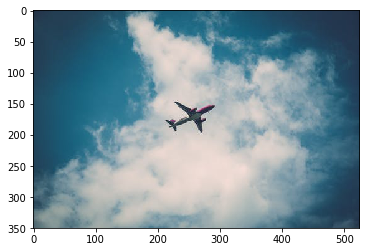

In [12]:
import matplotlib.pyplot as plt


model_path = 'weights/show-and-tell.pb'
vocab_file = 'data/word_counts.txt'
input_files = 'ImageDoc/plane.jpg'

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)


def main(_):
    model = ShowAndTellModel(model_path)
    vocab = Vocabulary(vocab_file)
    filenames = _load_filenames()

    generator = CaptionGenerator(model, vocab)

    for filename in filenames:
        with tf.gfile.GFile(filename, "rb") as f:
            image = f.read()
        captions = generator.beam_search(image)
        print("Captions for image %s:" % os.path.basename(filename))
        for i, caption in enumerate(captions):
            # Ignore begin and end tokens <S> and </S>.
            sentence = [vocab.id_to_token(w) for w in caption.sentence[1:-1]]
            sentence = " ".join(sentence)
            print("  %d) %s (p=%f)" % (i, sentence, math.exp(caption.logprob)))
    img = plt.imread(input_files)
    plt.imshow(img)

def _load_filenames():
    filenames = []
    for file_pattern in input_files.split(","):
        filenames.extend(tf.gfile.Glob(file_pattern))
    logger.info("Running caption generation on %d files matching %s",
                len(filenames), input_files)
    return filenames


if __name__ == "__main__":
    tf.app.run()
    
    